In [1]:
import sys

sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

# SwissMetro

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
import seaborn as sns
import copy
import os
import numpy as np
from biogeme.results import bioResults
from sklearn.preprocessing import MinMaxScaler

#rumboost imports
from rumboost.datasets import load_preprocess_SwissMetro
from rumboost.post_process import (
    predict_with_assisted_spec,
)
from rumboost.rumboost import RUMBoost

#project imports
from helper import set_all_seeds
from constants import (
    sm_bin_vars,
    sm_cont_vars,
    sm_structure,
    sm_monotone_constraints,
    PATH_TO_DATA,
)
from utils import transform_mono_cons, transform_vars_list, augment_dataset
from simple_mnl import SwissMetro_normalised

In [4]:
dataset_loader = {
    "SwissMetro": load_preprocess_SwissMetro,
}

dataset_vars = {
    "SwissMetro": (sm_bin_vars, sm_cont_vars),
}

dataset_structure = {
    "SwissMetro": sm_structure,
}
dataset_monotone_constraints = {
    "SwissMetro": sm_monotone_constraints,
}
dataset_num_classes = {
    "LPMC": 4,
    "SwissMetro": 3,
}

# set the random seed for reproducibility
set_all_seeds(42)

data_train, data_test, folds = dataset_loader["SwissMetro"](path=PATH_TO_DATA)

target = "choice"
y_train = data_train[target]
y_test = data_test[target]

bin_vars, cont_vars = dataset_vars["SwissMetro"]

X_train = augment_dataset(data_train, cont_vars, type="constant_linear")
X_test = augment_dataset(data_test, cont_vars, type="constant_linear")
X_train_bin = augment_dataset(data_train, bin_vars, type="constant")
X_test_bin = augment_dataset(data_test, bin_vars, type="constant")
X_train = pd.concat([X_train, X_train_bin], axis=1)
X_test = pd.concat([X_test, X_test_bin], axis=1)

# transform the monotone constraints to a specific format
monotone_constraints = transform_mono_cons(
    dataset_monotone_constraints["SwissMetro"],
    "constant_linear",
    cont_vars,
)
# binary variables are never boosted from parameter space
new_bin_vars = transform_vars_list(bin_vars, "constant", bin_vars)
bin_vars = new_bin_vars

structure = copy.deepcopy(dataset_structure["SwissMetro"])
for u in structure:
    structure[u] = (
        transform_vars_list(structure[u], "constant_linear", cont_vars) + bin_vars
    )
new_cont_vars = transform_vars_list(cont_vars, "constant_linear", cont_vars)
cont_vars = new_cont_vars

num_classes = dataset_num_classes["SwissMetro"]

# scale the features
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [5]:
#loading models

pwl_pickle = "results/SwissMetro/assisted_specification/assisted_model_pwlinear.pickle"
pwl_dcm = bioResults(pickle_file=pwl_pickle)

lin_pickle = "results/SwissMetro/assisted_specification/SwissmetroMNL~.pickle"
lin_dcm = bioResults(pickle_file=lin_pickle)

lin_rumb = RUMBoost(
    model_file="results/SwissMetro/RUMBoost/linear/monoTrue/model_True.json"
)

lin_10bins_rumb = RUMBoost(
    model_file="results/SwissMetro/RUMBoost/linear/monoTrue/model_True_10bins.json"
)


lin_const_rumb = RUMBoost(
    model_file="results/SwissMetro/RUMBoost/constant_linear/monoTrue/model_True.json"
)

const_rumb = RUMBoost(
    model_file="results/SwissMetro/RUMBoost/constant/monoTrue/model_True.json"
)

#dummy dataset to simulate features when plotting
plot_dataset = pd.DataFrame(columns=X_train.columns)
x_plot = np.linspace(0, 1, 10000)
for col in X_train.columns:
    plot_dataset[col] = np.zeros_like(x_plot)

## Utility and parameters plots

### PWC-RUMBoost and PWL-RUMBoost only

In [25]:
path_to_save = "results/SwissMetro/figures/rumboost/"
os.makedirs(path_to_save, exist_ok=True)

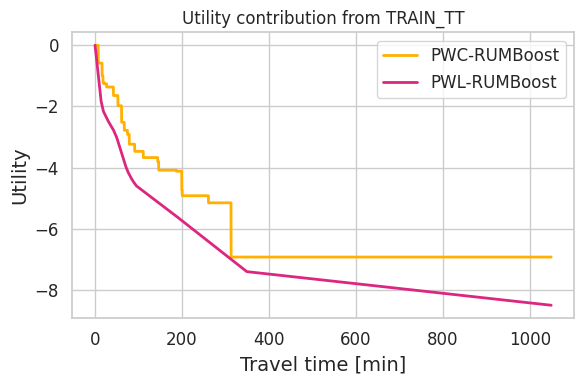

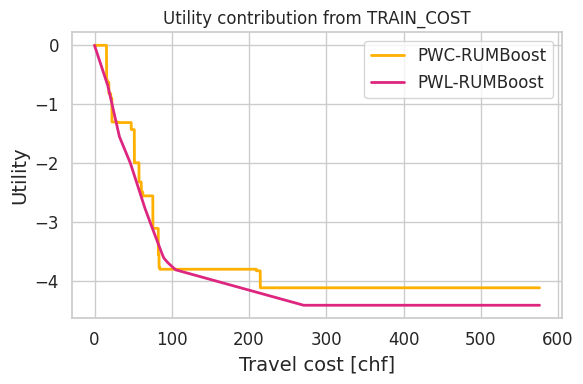

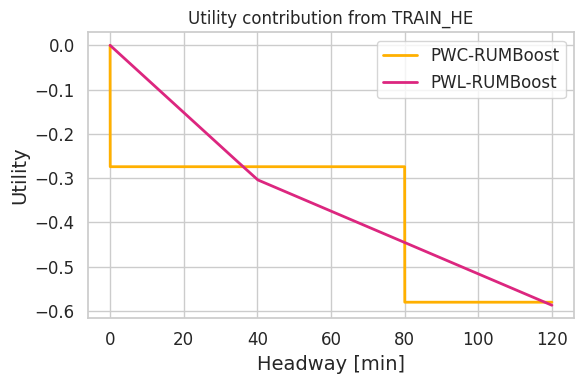

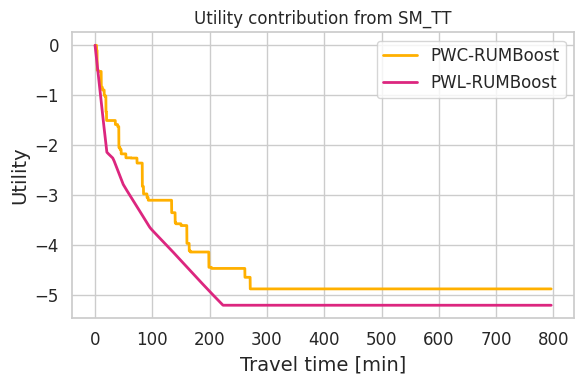

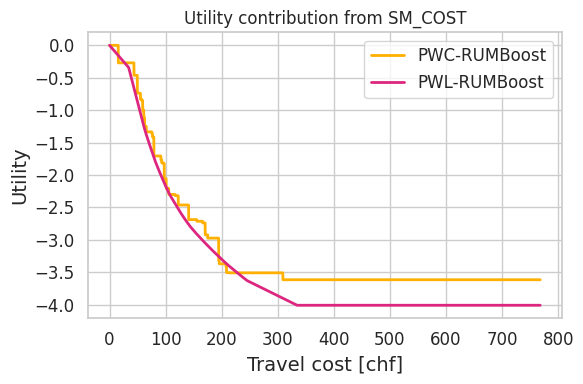

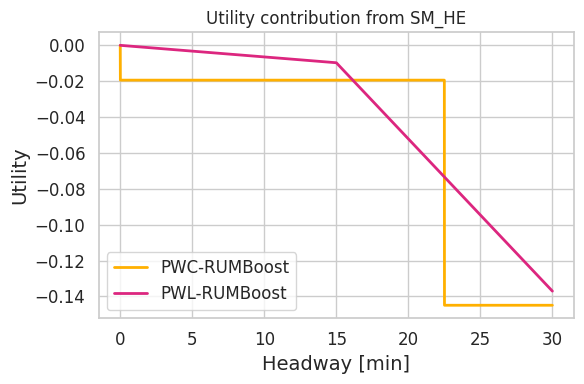

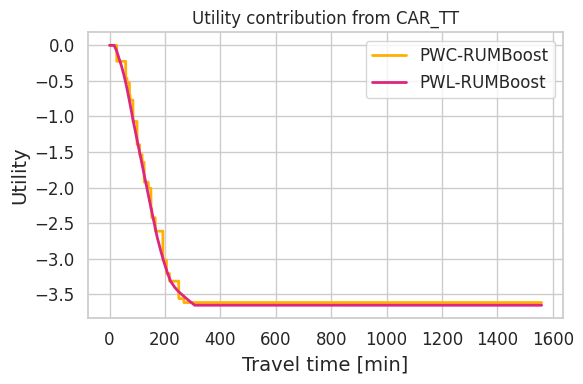

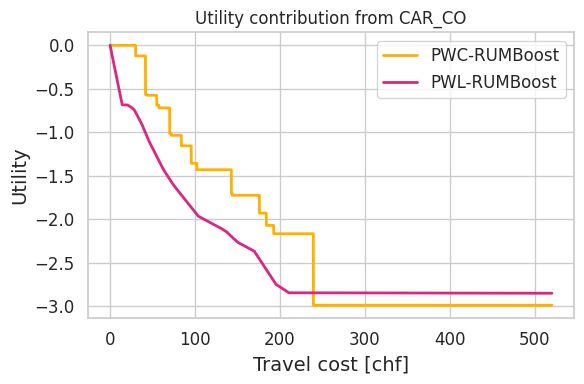

In [26]:
sns.set_theme(style="whitegrid")

models = {
    "MNL": lin_dcm,
    "PWL-MNL": pwl_dcm,
    "Const-RUMBoost": const_rumb,
    "PWL-Const-RUMBoost": lin_const_rumb,
    "PWL-RUMBoost": lin_rumb,
}
vars = [
    "TRAIN_TT",
    "TRAIN_COST",
    "TRAIN_HE",
    "SM_TT",
    "SM_COST",
    "SM_HE",
    "CAR_TT",
    "CAR_CO",
]

label_name = {
    "MNL": "MNL",
    "PWL-MNL": "PWL-MNL",
    "Const-RUMBoost": "PWC-RUMBoost",
    "PWL-Const-RUMBoost": "PWL+PWC-RUMBoost",
    "PWL-RUMBoost": "PWL-RUMBoost",
}

y_plot_mnl = []
y_plot_pwl = []
y_plot_crumb = []
y_plot_pwlcrumb = []
y_plot_pwl_rumb = []

y_plot = {
    "MNL": y_plot_mnl,
    "PWL-MNL": y_plot_pwl,
    "Const-RUMBoost": y_plot_crumb,
    "PWL-Const-RUMBoost": y_plot_pwlcrumb,
    "PWL-RUMBoost": y_plot_pwl_rumb,
}

for v in vars:
    if "TRAIN" in v:
        u = "0"
    elif "SM" in v:
        u = "1"
    elif "CAR" in v:
        u = "2"
    cols = [col for col in plot_dataset.columns if v in col]
    dummy_data = plot_dataset.copy()
    dummy_data[cols] = x_plot.reshape(-1, 1).repeat(len(cols), axis=1)
    dummy_data["choice"] = np.zeros_like(x_plot)
    for model_name, model in models.items():
        if model_name == "MNL":
            model_spec = SwissMetro_normalised(dummy_data, for_prob=True)
            preds = model_spec.simulate(lin_dcm.get_beta_values())[u]
            preds = preds - preds[0]
            y_plot_mnl.append(preds)
        elif model_name == "PWL-MNL":
            preds = predict_with_assisted_spec(
                dummy_data.drop(columns=["choice"]),
                dummy_data.drop(columns=["choice"]),
                np.zeros(dummy_data.shape[0]),
                np.zeros(dummy_data.shape[0]),
                lin_10bins_rumb,
                pwl_dcm.get_beta_values(),
                utilities=True,
            )[u]
            preds = preds - preds[0]
            y_plot_pwl.append(preds)
        elif model_name == "Const-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_crumb.append(preds)
        elif model_name == "PWL-Const-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_pwlcrumb.append(preds)
        elif model_name == "PWL-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_pwl_rumb.append(preds)

colors = ["#648FFF", "#785EF0", "#FFB000", "#FE6100", "#DC267F"]

linestyles = ["-", "-", "-", "-", "-"]

for i, v in enumerate(vars):
    plt.figure(figsize=(6, 4))
    plt.title(f"Utility contribution from {v}")
    for j, model_name in enumerate(models.keys()):
        if j < 2:
            continue
        if j == 3:
            continue
        plt.plot(
            x_plot * X_train[v + "_constant"].max(),
            y_plot[model_name][i],
            label=label_name[model_name],
            linewidth=2,
            color=colors[j],
            linestyle=linestyles[j],
        )

    xlabel = (
        "Travel time [min]"
        if "TT" in v
        else "Travel cost [chf]" if "CO" in v else "Headway [min]"
    )
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("Utility", fontsize=14)
    #plt.ylim((y_plot["PWL-Const-RUMBoost"][i].min() * 1.05, -y_plot["PWL-Const-RUMBoost"][i].min()*0.05))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig(f"{path_to_save}utility_functions_{v}.png")

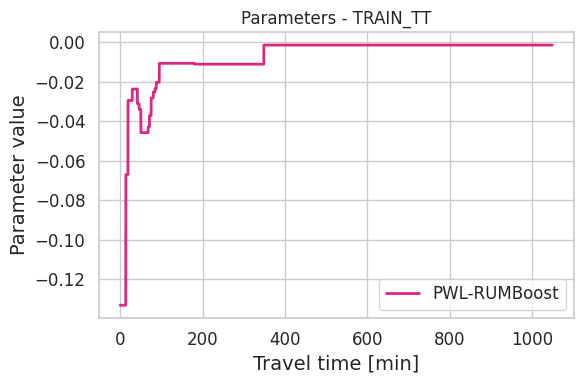

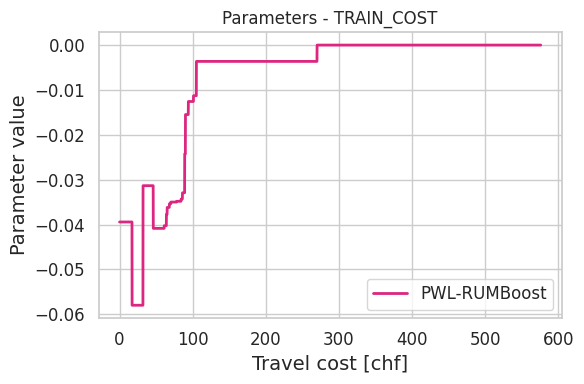

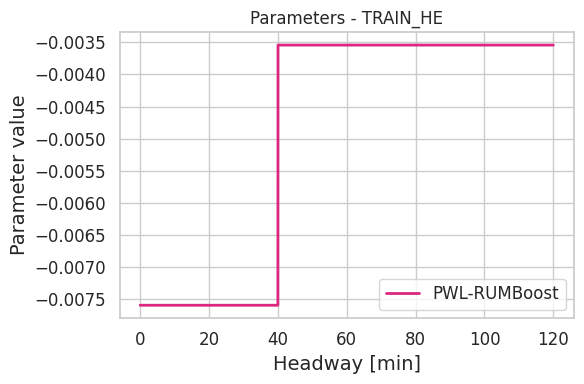

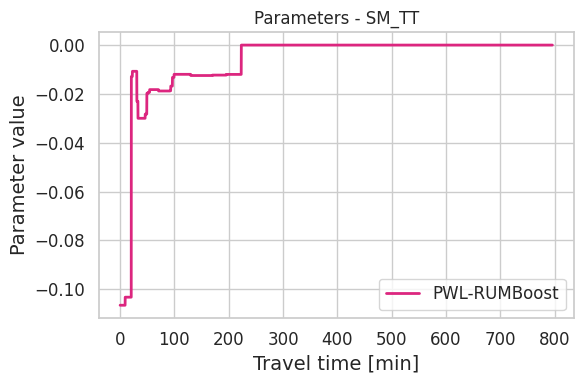

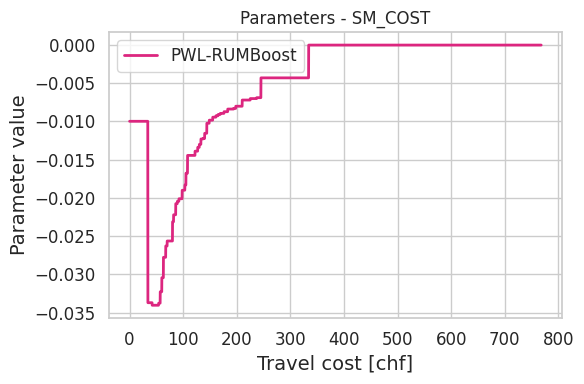

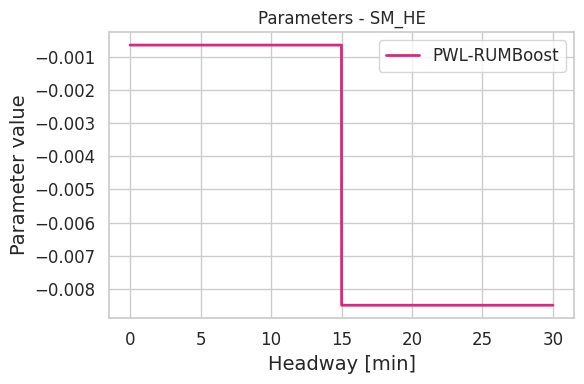

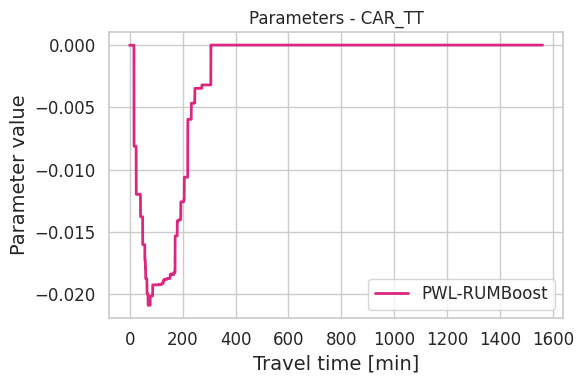

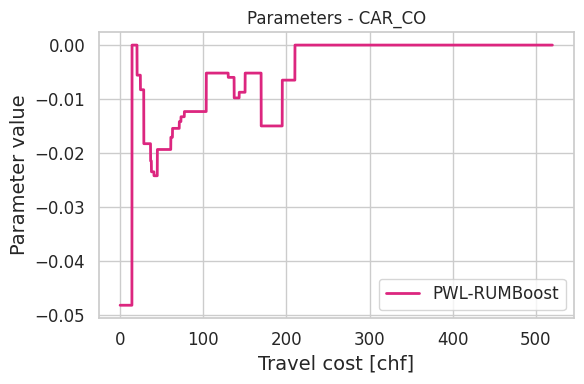

In [11]:
from rumboost.post_process import predict_with_assisted_spec
import matplotlib.pyplot as plt
import lightgbm
import seaborn as sns

sns.set_theme(style="whitegrid")

models = {
    "MNL": lin_dcm,
    "PWL-MNL": pwl_dcm,
    "PWL-Const-RUMBoost": lin_const_rumb,
    "PWL-RUMBoost": lin_rumb,
}
vars = [
    "TRAIN_TT",
    "TRAIN_COST",
    "TRAIN_HE",
    "SM_TT",
    "SM_COST",
    "SM_HE",
    "CAR_TT",
    "CAR_CO",
]
vars_to_b = {
    "TRAIN_TT": "B_TIME_RAIL",
    "TRAIN_COST": "B_COST_RAIL",
    "TRAIN_HE": "B_HE_RAIL",
    "SM_TT": "B_TIME_SM",
    "SM_COST": "B_COST_SM",
    "SM_HE": "B_HE_SM",
    "CAR_TT": "B_TIME_CAR",
    "CAR_CO": "B_COST_CAR",
}

label_name = {
    "MNL": "MNL",
    "PWL-MNL": "PWL-MNL",
    "Const-RUMBoost": "PWC-RUMBoost",
    "PWL-Const-RUMBoost": "PWL+PWC-RUMBoost",
    "PWL-RUMBoost": "PWL-RUMBoost",
}

y_plot_mnl = []
y_plot_pwl = []
y_plot_crumb = []
y_plot_pwlcrumb = []
y_plot_pwl_rumb = []

y_plot = {
    "MNL": y_plot_mnl,
    "PWL-MNL": y_plot_pwl,
    "PWL-Const-RUMBoost": y_plot_pwlcrumb,
    "PWL-RUMBoost": y_plot_pwl_rumb,
}

for v in vars:
    if "TRAIN" in v:
        u = "0"
    elif "SM" in v:
        u = "1"
    elif "CAR" in v:
        u = "2"
    cols = [col for col in plot_dataset.columns if v in col]
    dummy_data = plot_dataset.copy()
    dummy_data[cols] = x_plot.reshape(-1, 1).repeat(len(cols), axis=1)
    dummy_data["choice"] = np.zeros_like(x_plot)

    for model_name, model in models.items():

        if model_name == "PWL-Const-RUMBoost":
            booster_idx = [
                i
                for i, struct in enumerate(model.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            leaves = model.boosters[booster_idx].split_and_leaf_values["leaves"]
            splits = model.boosters[booster_idx].split_and_leaf_values["splits"]
            preds = leaves[
                np.clip(np.searchsorted(splits, x_plot) - 1, 0, len(leaves) - 1)
            ]
            y_plot_pwlcrumb.append(preds)
        elif model_name == "PWL-RUMBoost":
            booster_idx = [
                i
                for i, struct in enumerate(model.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            leaves = model.boosters[booster_idx].split_and_leaf_values["leaves"]
            splits = model.boosters[booster_idx].split_and_leaf_values["splits"]
            preds = leaves[
                np.clip(np.searchsorted(splits, x_plot) - 1, 0, len(leaves) - 1)
            ]
            y_plot_pwl_rumb.append(preds)
        elif model_name == "MNL":
            parameters = model.get_estimated_parameters()
            preds = parameters.loc[vars_to_b[v], "Value"] * np.ones_like(x_plot)
            y_plot_mnl.append(preds)
        elif model_name == "PWL-MNL":
            booster_idx = [
                i
                for i, struct in enumerate(lin_10bins_rumb.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            splits = lin_10bins_rumb.boosters[booster_idx].split_and_leaf_values[
                "splits"
            ]
            leaves = lin_10bins_rumb.boosters[booster_idx].split_and_leaf_values[
                "leaves"
            ]

            leaf_change_idx = np.where(leaves[:-1] != leaves[1:])[0]
            unique_splits = splits[leaf_change_idx + 1]
            indices = np.searchsorted(unique_splits, x_plot)
            parameters = model.get_estimated_parameters()
            preds = np.array(
                [
                    parameters.loc[f"b_{v}_linear_{booster_idx}_{i}", "Value"]
                    for i in indices
                ]
            )
            y_plot_pwl.append(preds)

colors = ["#648FFF", "#785EF0", "#FE6100", "#DC267F"]

linestyles = ["-", "-", "-", "-", "-"]

for i, v in enumerate(vars):
    plt.figure(figsize=(6, 4))
    plt.title(f"Parameters - {v}")
    for j, model_name in enumerate(models.keys()):
        if j < 3:
            continue
        plt.plot(
            x_plot * X_train[v + "_constant"].max(),
            y_plot[model_name][i] / X_train[v + "_constant"].max(),
            label=label_name[model_name],
            linewidth=2,
            color=colors[j],
            linestyle=linestyles[j],
        )

    xlabel = (
        "Travel time [min]"
        if "TT" in v
        else "Travel cost [chf]" if "CO" in v else "Headway [min]"
    )
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("Parameter value", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig(f"{path_to_save}parameters_{v}.png")

### PWC-RUMBoost and PWL-RUMBoost and PWC-PWL-RUMBoost

In [13]:
path_to_save = "results/SwissMetro/figures/rumboost_combined/"
os.makedirs(path_to_save, exist_ok=True)

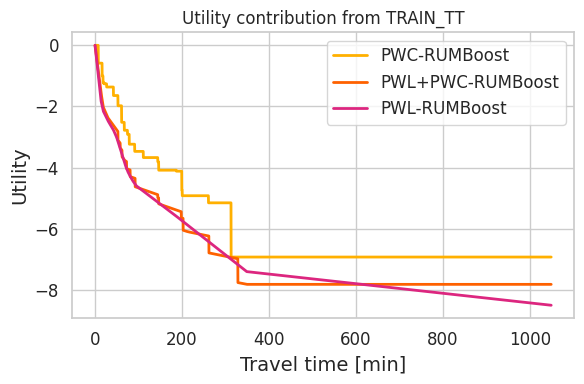

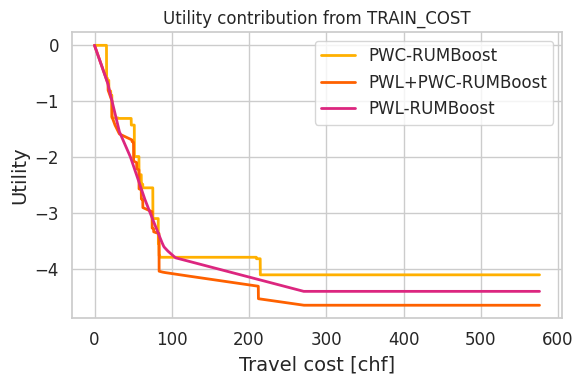

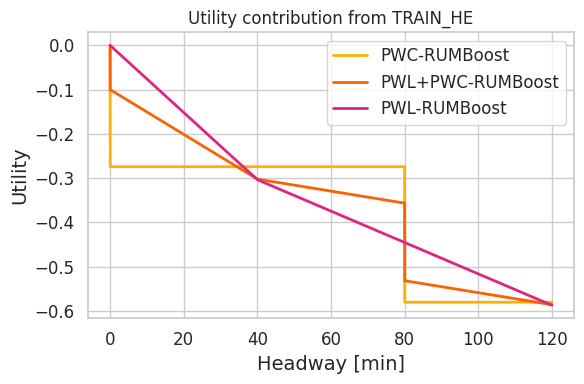

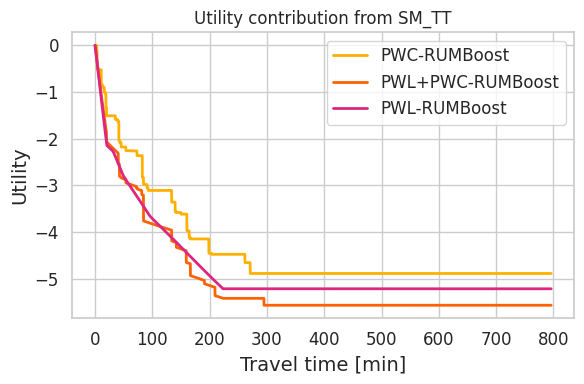

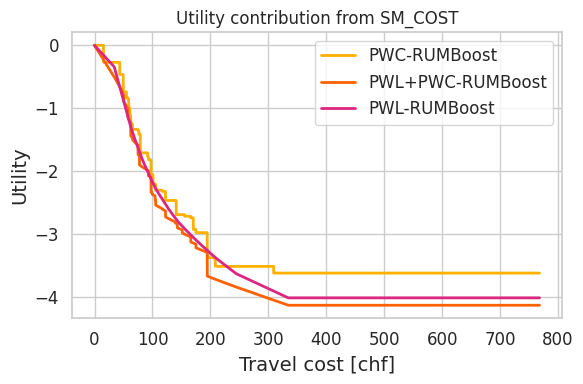

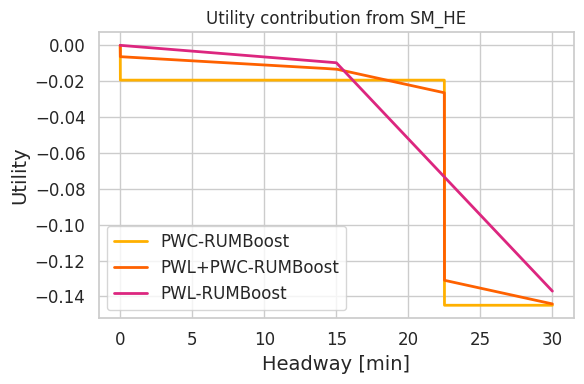

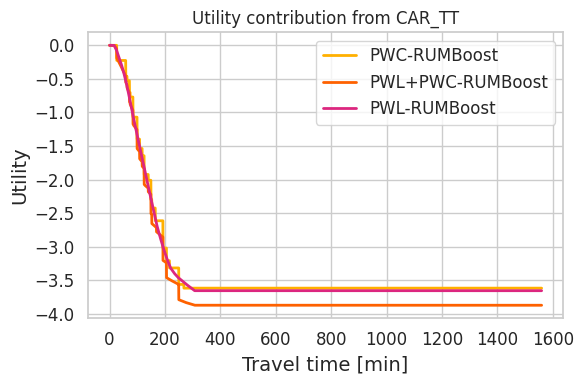

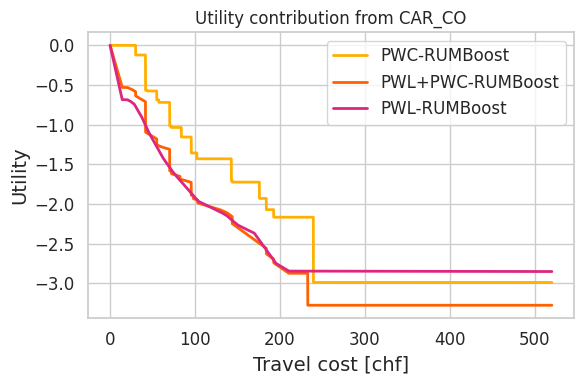

In [14]:
sns.set_theme(style="whitegrid")

models = {
    "MNL": lin_dcm,
    "PWL-MNL": pwl_dcm,
    "Const-RUMBoost": const_rumb,
    "PWL-Const-RUMBoost": lin_const_rumb,
    "PWL-RUMBoost": lin_rumb,
}
vars = [
    "TRAIN_TT",
    "TRAIN_COST",
    "TRAIN_HE",
    "SM_TT",
    "SM_COST",
    "SM_HE",
    "CAR_TT",
    "CAR_CO",
]

label_name = {
    "MNL": "MNL",
    "PWL-MNL": "PWL-MNL",
    "Const-RUMBoost": "PWC-RUMBoost",
    "PWL-Const-RUMBoost": "PWL+PWC-RUMBoost",
    "PWL-RUMBoost": "PWL-RUMBoost",
}

y_plot_mnl = []
y_plot_pwl = []
y_plot_crumb = []
y_plot_pwlcrumb = []
y_plot_pwl_rumb = []

y_plot = {
    "MNL": y_plot_mnl,
    "PWL-MNL": y_plot_pwl,
    "Const-RUMBoost": y_plot_crumb,
    "PWL-Const-RUMBoost": y_plot_pwlcrumb,
    "PWL-RUMBoost": y_plot_pwl_rumb,
}

for v in vars:
    if "TRAIN" in v:
        u = "0"
    elif "SM" in v:
        u = "1"
    elif "CAR" in v:
        u = "2"
    cols = [col for col in plot_dataset.columns if v in col]
    dummy_data = plot_dataset.copy()
    dummy_data[cols] = x_plot.reshape(-1, 1).repeat(len(cols), axis=1)
    dummy_data["choice"] = np.zeros_like(x_plot)
    for model_name, model in models.items():
        if model_name == "MNL":
            model_spec = SwissMetro_normalised(dummy_data, for_prob=True)
            preds = model_spec.simulate(lin_dcm.get_beta_values())[u]
            preds = preds - preds[0]
            y_plot_mnl.append(preds)
        elif model_name == "PWL-MNL":
            preds = predict_with_assisted_spec(
                dummy_data.drop(columns=["choice"]),
                dummy_data.drop(columns=["choice"]),
                np.zeros(dummy_data.shape[0]),
                np.zeros(dummy_data.shape[0]),
                lin_10bins_rumb,
                pwl_dcm.get_beta_values(),
                utilities=True,
            )[u]
            preds = preds - preds[0]
            y_plot_pwl.append(preds)
        elif model_name == "Const-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_crumb.append(preds)
        elif model_name == "PWL-Const-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_pwlcrumb.append(preds)
        elif model_name == "PWL-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_pwl_rumb.append(preds)

colors = ["#648FFF", "#785EF0", "#FFB000", "#FE6100", "#DC267F"]

linestyles = ["-", "-", "-", "-", "-"]

for i, v in enumerate(vars):
    plt.figure(figsize=(6, 4))
    plt.title(f"Utility contribution from {v}")
    for j, model_name in enumerate(models.keys()):
        if j < 2:
            continue
        # if j == 3:
        #     continue
        plt.plot(
            x_plot * X_train[v + "_constant"].max(),
            y_plot[model_name][i],
            label=label_name[model_name],
            linewidth=2,
            color=colors[j],
            linestyle=linestyles[j],
        )

    xlabel = (
        "Travel time [min]"
        if "TT" in v
        else "Travel cost [chf]" if "CO" in v else "Headway [min]"
    )
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("Utility", fontsize=14)
    #plt.ylim((y_plot["PWL-Const-RUMBoost"][i].min() * 1.05, -y_plot["PWL-Const-RUMBoost"][i].min()*0.05))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig(f"{path_to_save}utility_functions_{v}.png")

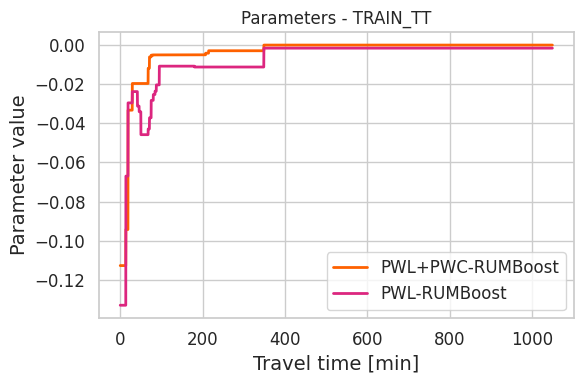

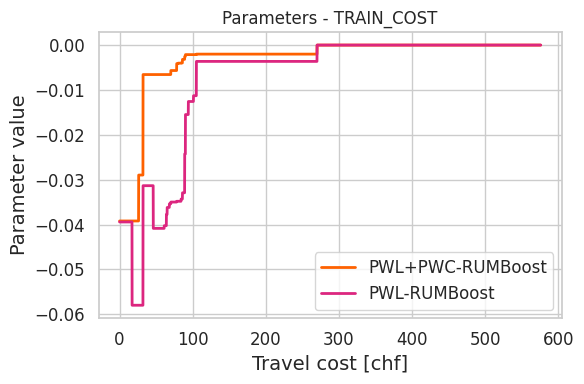

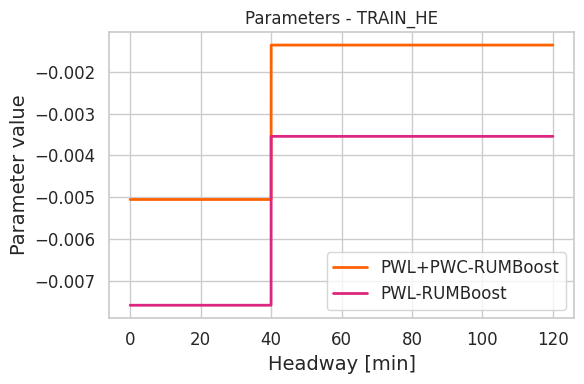

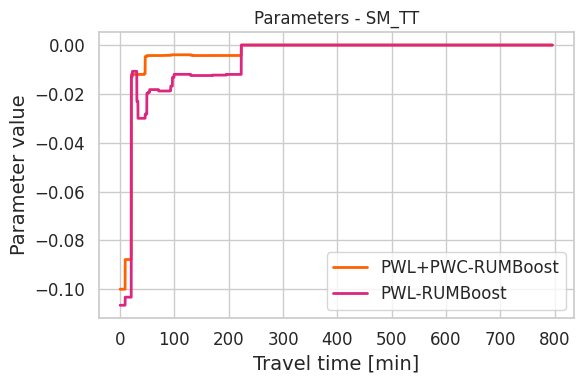

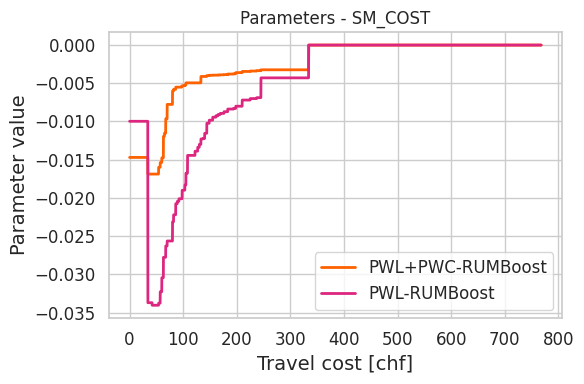

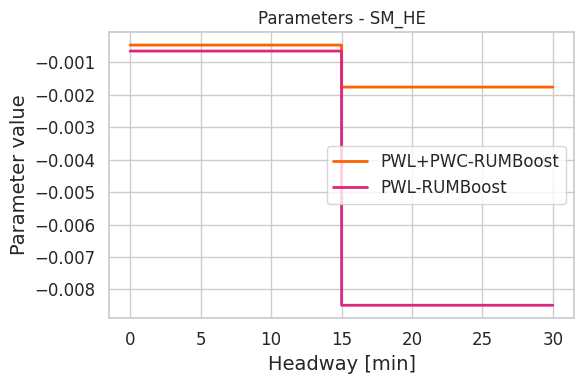

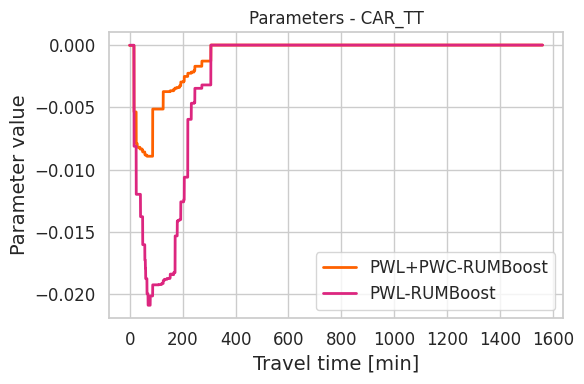

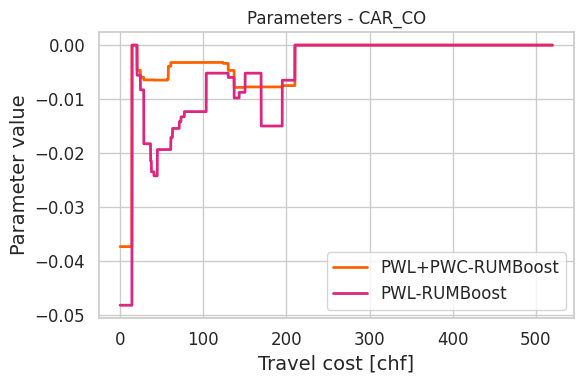

In [15]:
from rumboost.post_process import predict_with_assisted_spec
import matplotlib.pyplot as plt
import lightgbm
import seaborn as sns

sns.set_theme(style="whitegrid")

models = {
    "MNL": lin_dcm,
    "PWL-MNL": pwl_dcm,
    "PWL-Const-RUMBoost": lin_const_rumb,
    "PWL-RUMBoost": lin_rumb,
}
vars = [
    "TRAIN_TT",
    "TRAIN_COST",
    "TRAIN_HE",
    "SM_TT",
    "SM_COST",
    "SM_HE",
    "CAR_TT",
    "CAR_CO",
]
vars_to_b = {
    "TRAIN_TT": "B_TIME_RAIL",
    "TRAIN_COST": "B_COST_RAIL",
    "TRAIN_HE": "B_HE_RAIL",
    "SM_TT": "B_TIME_SM",
    "SM_COST": "B_COST_SM",
    "SM_HE": "B_HE_SM",
    "CAR_TT": "B_TIME_CAR",
    "CAR_CO": "B_COST_CAR",
}

label_name = {
    "MNL": "MNL",
    "PWL-MNL": "PWL-MNL",
    "Const-RUMBoost": "PWC-RUMBoost",
    "PWL-Const-RUMBoost": "PWL+PWC-RUMBoost",
    "PWL-RUMBoost": "PWL-RUMBoost",
}

y_plot_mnl = []
y_plot_pwl = []
y_plot_crumb = []
y_plot_pwlcrumb = []
y_plot_pwl_rumb = []

y_plot = {
    "MNL": y_plot_mnl,
    "PWL-MNL": y_plot_pwl,
    "PWL-Const-RUMBoost": y_plot_pwlcrumb,
    "PWL-RUMBoost": y_plot_pwl_rumb,
}

for v in vars:
    if "TRAIN" in v:
        u = "0"
    elif "SM" in v:
        u = "1"
    elif "CAR" in v:
        u = "2"
    cols = [col for col in plot_dataset.columns if v in col]
    dummy_data = plot_dataset.copy()
    dummy_data[cols] = x_plot.reshape(-1, 1).repeat(len(cols), axis=1)
    dummy_data["choice"] = np.zeros_like(x_plot)

    for model_name, model in models.items():

        if model_name == "PWL-Const-RUMBoost":
            booster_idx = [
                i
                for i, struct in enumerate(model.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            leaves = model.boosters[booster_idx].split_and_leaf_values["leaves"]
            splits = model.boosters[booster_idx].split_and_leaf_values["splits"]
            preds = leaves[
                np.clip(np.searchsorted(splits, x_plot) - 1, 0, len(leaves) - 1)
            ]
            y_plot_pwlcrumb.append(preds)
        elif model_name == "PWL-RUMBoost":
            booster_idx = [
                i
                for i, struct in enumerate(model.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            leaves = model.boosters[booster_idx].split_and_leaf_values["leaves"]
            splits = model.boosters[booster_idx].split_and_leaf_values["splits"]
            preds = leaves[
                np.clip(np.searchsorted(splits, x_plot) - 1, 0, len(leaves) - 1)
            ]
            y_plot_pwl_rumb.append(preds)
        elif model_name == "MNL":
            parameters = model.get_estimated_parameters()
            preds = parameters.loc[vars_to_b[v], "Value"] * np.ones_like(x_plot)
            y_plot_mnl.append(preds)
        elif model_name == "PWL-MNL":
            booster_idx = [
                i
                for i, struct in enumerate(lin_10bins_rumb.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            splits = lin_10bins_rumb.boosters[booster_idx].split_and_leaf_values[
                "splits"
            ]
            leaves = lin_10bins_rumb.boosters[booster_idx].split_and_leaf_values[
                "leaves"
            ]

            leaf_change_idx = np.where(leaves[:-1] != leaves[1:])[0]
            unique_splits = splits[leaf_change_idx + 1]
            indices = np.searchsorted(unique_splits, x_plot)
            parameters = model.get_estimated_parameters()
            preds = np.array(
                [
                    parameters.loc[f"b_{v}_linear_{booster_idx}_{i}", "Value"]
                    for i in indices
                ]
            )
            y_plot_pwl.append(preds)

colors = ["#648FFF", "#785EF0", "#FE6100", "#DC267F"]

linestyles = ["-", "-", "-", "-", "-"]

for i, v in enumerate(vars):
    plt.figure(figsize=(6, 4))
    plt.title(f"Parameters - {v}")
    for j, model_name in enumerate(models.keys()):
        if j < 2:
            continue
        plt.plot(
            x_plot * X_train[v + "_constant"].max(),
            y_plot[model_name][i] / X_train[v + "_constant"].max(),
            label=label_name[model_name],
            linewidth=2,
            color=colors[j],
            linestyle=linestyles[j],
        )

    xlabel = (
        "Travel time [min]"
        if "TT" in v
        else "Travel cost [chf]" if "CO" in v else "Headway [min]"
    )
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("Parameter value", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig(f"{path_to_save}parameters_{v}.png")

### PWC-RUMBoost and PWL-RUMBoost and DCMs

In [16]:
path_to_save = "results/SwissMetro/figures/rumboost_and_dcms/"
os.makedirs(path_to_save, exist_ok=True)

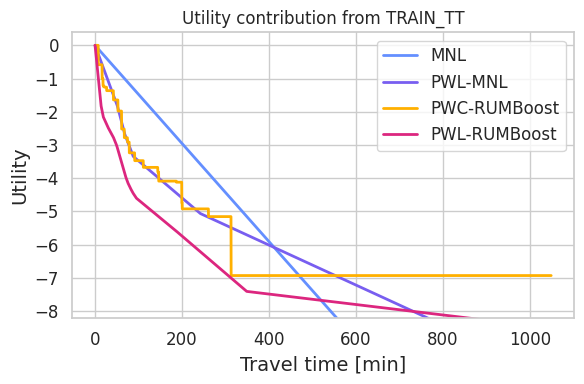

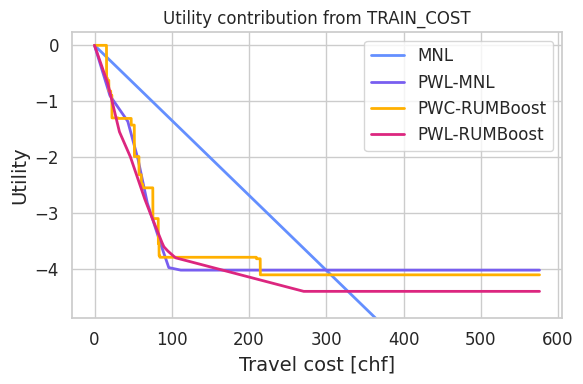

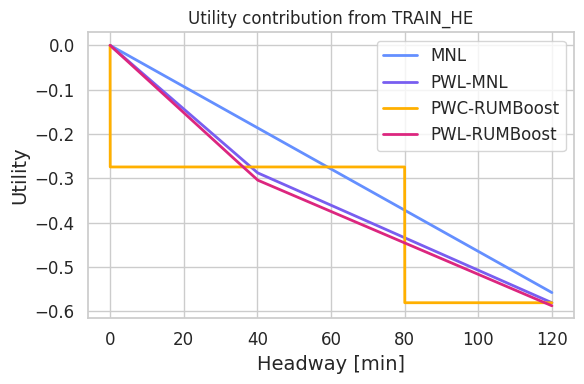

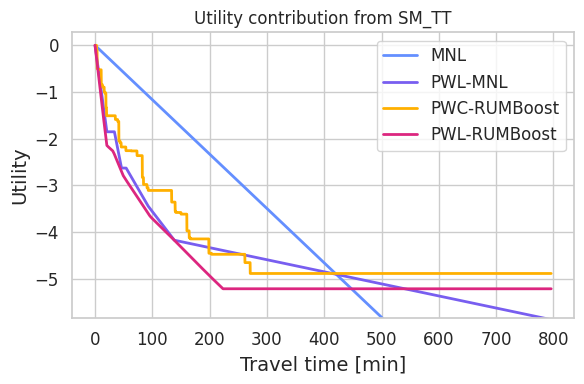

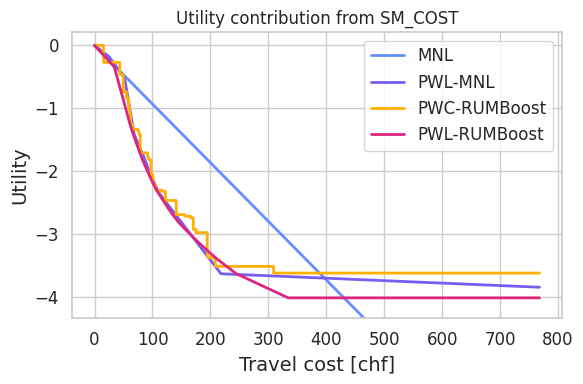

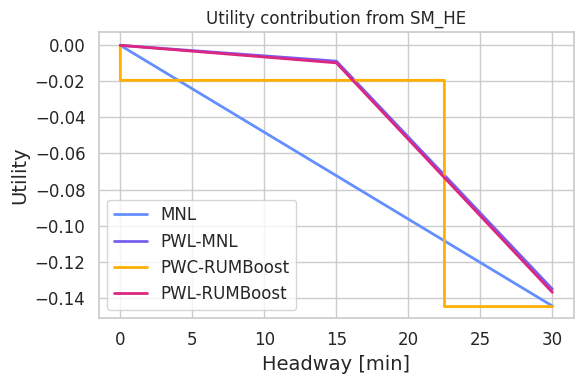

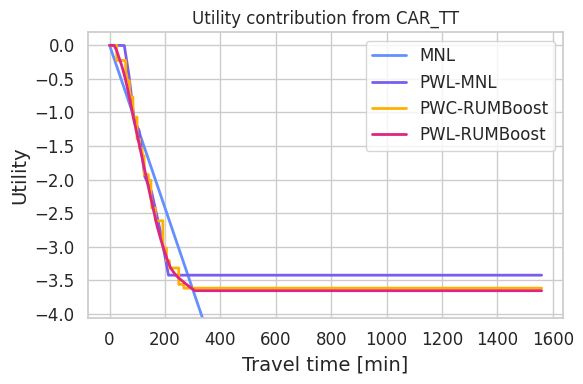

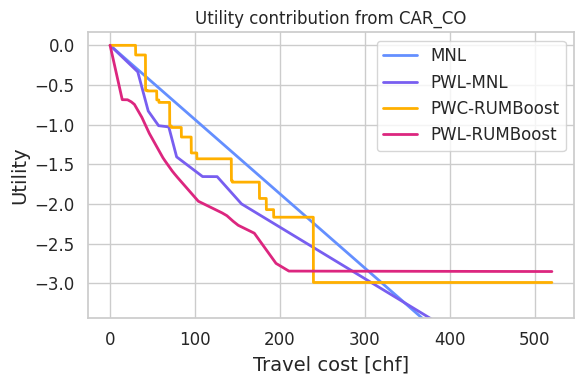

In [18]:
sns.set_theme(style="whitegrid")

models = {
    "MNL": lin_dcm,
    "PWL-MNL": pwl_dcm,
    "Const-RUMBoost": const_rumb,
    "PWL-Const-RUMBoost": lin_const_rumb,
    "PWL-RUMBoost": lin_rumb,
}
vars = [
    "TRAIN_TT",
    "TRAIN_COST",
    "TRAIN_HE",
    "SM_TT",
    "SM_COST",
    "SM_HE",
    "CAR_TT",
    "CAR_CO",
]

label_name = {
    "MNL": "MNL",
    "PWL-MNL": "PWL-MNL",
    "Const-RUMBoost": "PWC-RUMBoost",
    "PWL-Const-RUMBoost": "PWL+PWC-RUMBoost",
    "PWL-RUMBoost": "PWL-RUMBoost",
}

y_plot_mnl = []
y_plot_pwl = []
y_plot_crumb = []
y_plot_pwlcrumb = []
y_plot_pwl_rumb = []

y_plot = {
    "MNL": y_plot_mnl,
    "PWL-MNL": y_plot_pwl,
    "Const-RUMBoost": y_plot_crumb,
    "PWL-Const-RUMBoost": y_plot_pwlcrumb,
    "PWL-RUMBoost": y_plot_pwl_rumb,
}

for v in vars:
    if "TRAIN" in v:
        u = "0"
    elif "SM" in v:
        u = "1"
    elif "CAR" in v:
        u = "2"
    cols = [col for col in plot_dataset.columns if v in col]
    dummy_data = plot_dataset.copy()
    dummy_data[cols] = x_plot.reshape(-1, 1).repeat(len(cols), axis=1)
    dummy_data["choice"] = np.zeros_like(x_plot)
    for model_name, model in models.items():
        if model_name == "MNL":
            model_spec = SwissMetro_normalised(dummy_data, for_prob=True)
            preds = model_spec.simulate(lin_dcm.get_beta_values())[u]
            preds = preds - preds[0]
            y_plot_mnl.append(preds)
        elif model_name == "PWL-MNL":
            preds = predict_with_assisted_spec(
                dummy_data.drop(columns=["choice"]),
                dummy_data.drop(columns=["choice"]),
                np.zeros(dummy_data.shape[0]),
                np.zeros(dummy_data.shape[0]),
                lin_10bins_rumb,
                pwl_dcm.get_beta_values(),
                utilities=True,
            )[u]
            preds = preds - preds[0]
            y_plot_pwl.append(preds)
        elif model_name == "Const-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_crumb.append(preds)
        elif model_name == "PWL-Const-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_pwlcrumb.append(preds)
        elif model_name == "PWL-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_pwl_rumb.append(preds)

colors = ["#648FFF", "#785EF0", "#FFB000", "#FE6100", "#DC267F"]

linestyles = ["-", "-", "-", "-", "-"]

for i, v in enumerate(vars):
    plt.figure(figsize=(6, 4))
    plt.title(f"Utility contribution from {v}")
    for j, model_name in enumerate(models.keys()):
        # if j < 2:
        #     continue
        if j == 3:
            continue
        plt.plot(
            x_plot * X_train[v + "_constant"].max(),
            y_plot[model_name][i],
            label=label_name[model_name],
            linewidth=2,
            color=colors[j],
            linestyle=linestyles[j],
        )

    xlabel = (
        "Travel time [min]"
        if "TT" in v
        else "Travel cost [chf]" if "CO" in v else "Headway [min]"
    )
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("Utility", fontsize=14)
    plt.ylim((y_plot["PWL-Const-RUMBoost"][i].min() * 1.05, -y_plot["PWL-Const-RUMBoost"][i].min()*0.05))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig(f"{path_to_save}utility_functions_{v}.png")

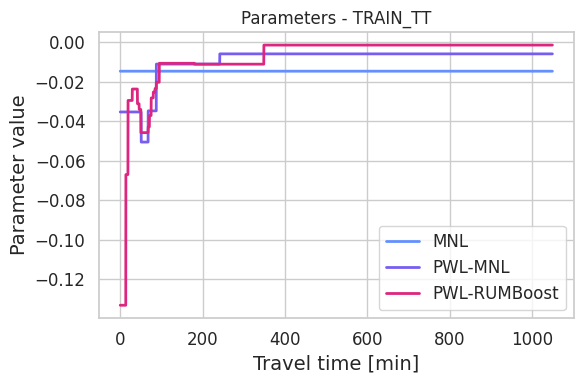

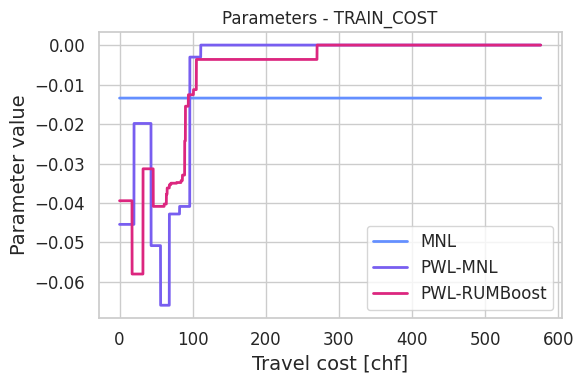

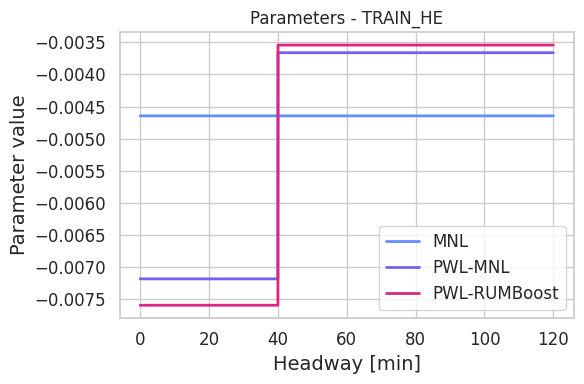

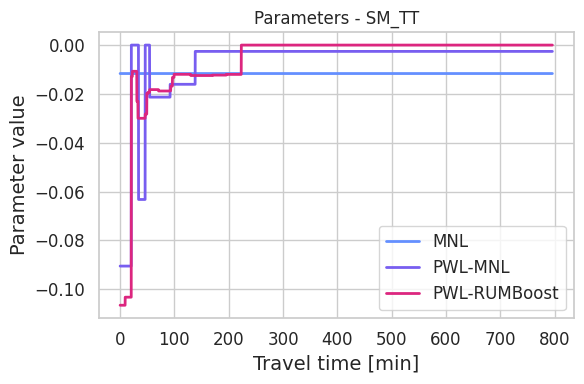

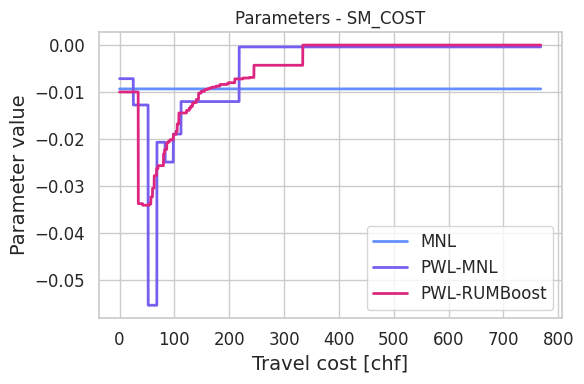

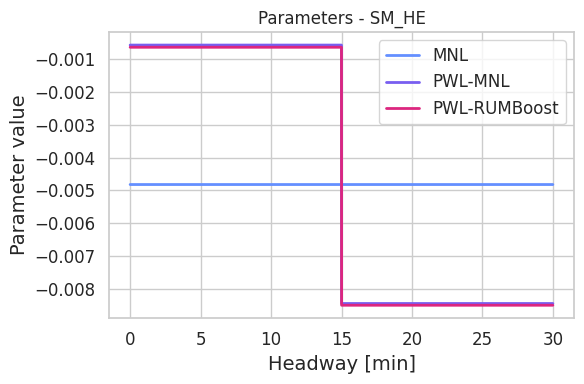

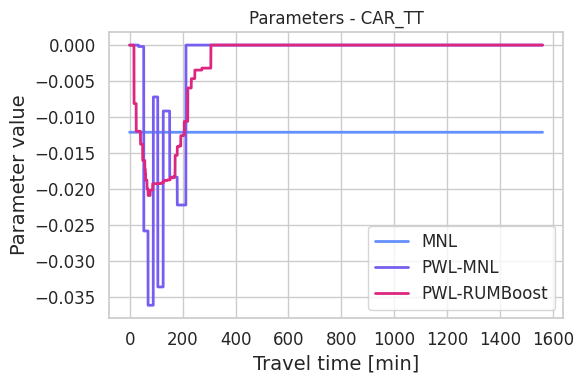

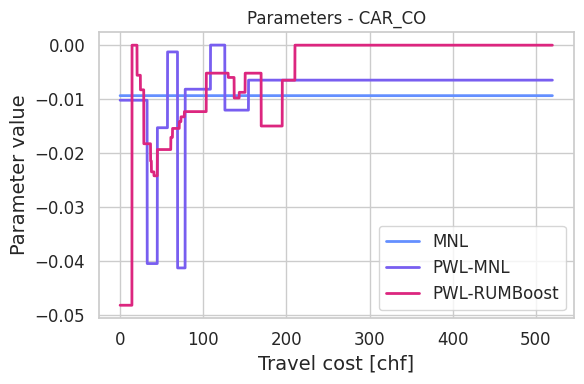

In [20]:
from rumboost.post_process import predict_with_assisted_spec
import matplotlib.pyplot as plt
import lightgbm
import seaborn as sns

sns.set_theme(style="whitegrid")

models = {
    "MNL": lin_dcm,
    "PWL-MNL": pwl_dcm,
    "PWL-Const-RUMBoost": lin_const_rumb,
    "PWL-RUMBoost": lin_rumb,
}
vars = [
    "TRAIN_TT",
    "TRAIN_COST",
    "TRAIN_HE",
    "SM_TT",
    "SM_COST",
    "SM_HE",
    "CAR_TT",
    "CAR_CO",
]
vars_to_b = {
    "TRAIN_TT": "B_TIME_RAIL",
    "TRAIN_COST": "B_COST_RAIL",
    "TRAIN_HE": "B_HE_RAIL",
    "SM_TT": "B_TIME_SM",
    "SM_COST": "B_COST_SM",
    "SM_HE": "B_HE_SM",
    "CAR_TT": "B_TIME_CAR",
    "CAR_CO": "B_COST_CAR",
}

label_name = {
    "MNL": "MNL",
    "PWL-MNL": "PWL-MNL",
    "Const-RUMBoost": "PWC-RUMBoost",
    "PWL-Const-RUMBoost": "PWL+PWC-RUMBoost",
    "PWL-RUMBoost": "PWL-RUMBoost",
}

y_plot_mnl = []
y_plot_pwl = []
y_plot_crumb = []
y_plot_pwlcrumb = []
y_plot_pwl_rumb = []

y_plot = {
    "MNL": y_plot_mnl,
    "PWL-MNL": y_plot_pwl,
    "PWL-Const-RUMBoost": y_plot_pwlcrumb,
    "PWL-RUMBoost": y_plot_pwl_rumb,
}

for v in vars:
    if "TRAIN" in v:
        u = "0"
    elif "SM" in v:
        u = "1"
    elif "CAR" in v:
        u = "2"
    cols = [col for col in plot_dataset.columns if v in col]
    dummy_data = plot_dataset.copy()
    dummy_data[cols] = x_plot.reshape(-1, 1).repeat(len(cols), axis=1)
    dummy_data["choice"] = np.zeros_like(x_plot)

    for model_name, model in models.items():

        if model_name == "PWL-Const-RUMBoost":
            booster_idx = [
                i
                for i, struct in enumerate(model.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            leaves = model.boosters[booster_idx].split_and_leaf_values["leaves"]
            splits = model.boosters[booster_idx].split_and_leaf_values["splits"]
            preds = leaves[
                np.clip(np.searchsorted(splits, x_plot) - 1, 0, len(leaves) - 1)
            ]
            y_plot_pwlcrumb.append(preds)
        elif model_name == "PWL-RUMBoost":
            booster_idx = [
                i
                for i, struct in enumerate(model.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            leaves = model.boosters[booster_idx].split_and_leaf_values["leaves"]
            splits = model.boosters[booster_idx].split_and_leaf_values["splits"]
            preds = leaves[
                np.clip(np.searchsorted(splits, x_plot) - 1, 0, len(leaves) - 1)
            ]
            y_plot_pwl_rumb.append(preds)
        elif model_name == "MNL":
            parameters = model.get_estimated_parameters()
            preds = parameters.loc[vars_to_b[v], "Value"] * np.ones_like(x_plot)
            y_plot_mnl.append(preds)
        elif model_name == "PWL-MNL":
            booster_idx = [
                i
                for i, struct in enumerate(lin_10bins_rumb.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            splits = lin_10bins_rumb.boosters[booster_idx].split_and_leaf_values[
                "splits"
            ]
            leaves = lin_10bins_rumb.boosters[booster_idx].split_and_leaf_values[
                "leaves"
            ]

            leaf_change_idx = np.where(leaves[:-1] != leaves[1:])[0]
            unique_splits = splits[leaf_change_idx + 1]
            indices = np.searchsorted(unique_splits, x_plot)
            parameters = model.get_estimated_parameters()
            preds = np.array(
                [
                    parameters.loc[f"b_{v}_linear_{booster_idx}_{i}", "Value"]
                    for i in indices
                ]
            )
            y_plot_pwl.append(preds)

colors = ["#648FFF", "#785EF0", "#FE6100", "#DC267F"]

linestyles = ["-", "-", "-", "-", "-"]

for i, v in enumerate(vars):
    plt.figure(figsize=(6, 4))
    plt.title(f"Parameters - {v}")
    for j, model_name in enumerate(models.keys()):
        if j == 2:
            continue
        plt.plot(
            x_plot * X_train[v + "_constant"].max(),
            y_plot[model_name][i] / X_train[v + "_constant"].max(),
            label=label_name[model_name],
            linewidth=2,
            color=colors[j],
            linestyle=linestyles[j],
        )

    xlabel = (
        "Travel time [min]"
        if "TT" in v
        else "Travel cost [chf]" if "CO" in v else "Headway [min]"
    )
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("Parameter value", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig(f"{path_to_save}parameters_{v}.png")

### PWC-RUMBoost and PWL-RUMBoost and PWC-PWL-RUMBoost

In [22]:
path_to_save = "results/SwissMetro/figures/rumboost_combined_and_dcms/"
os.makedirs(path_to_save, exist_ok=True)

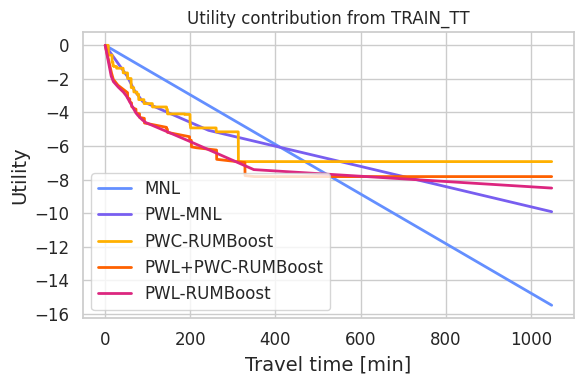

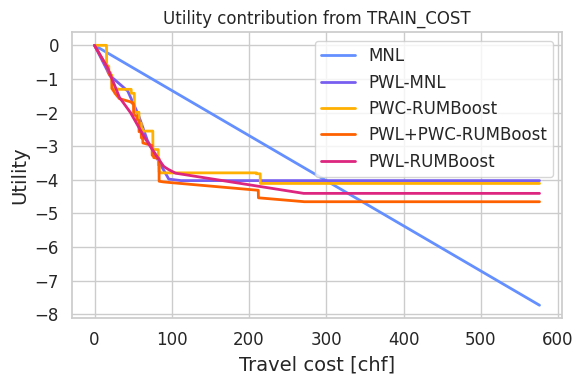

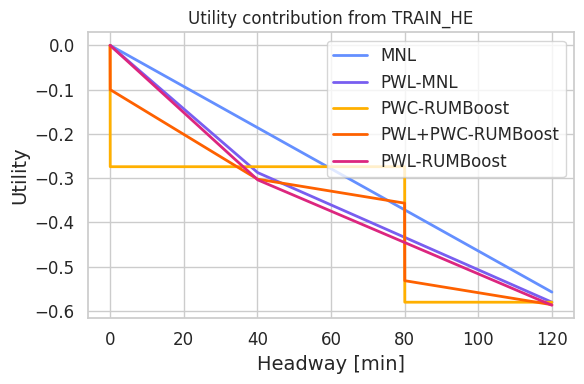

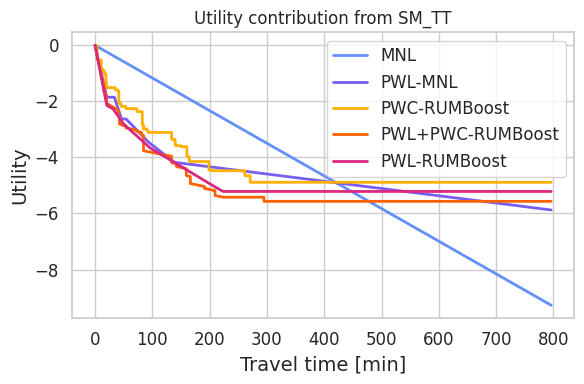

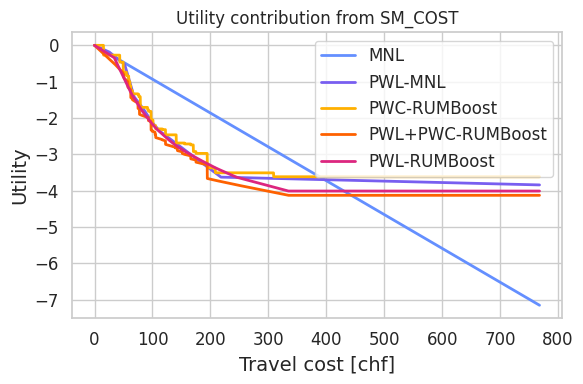

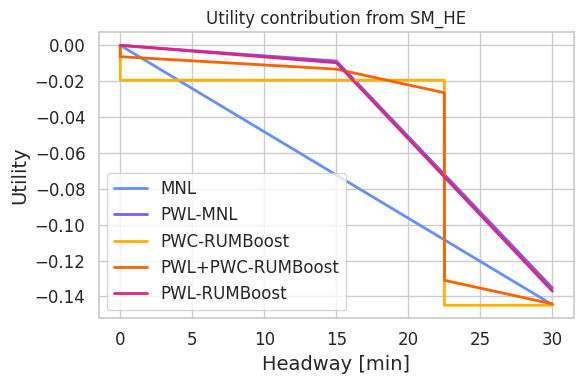

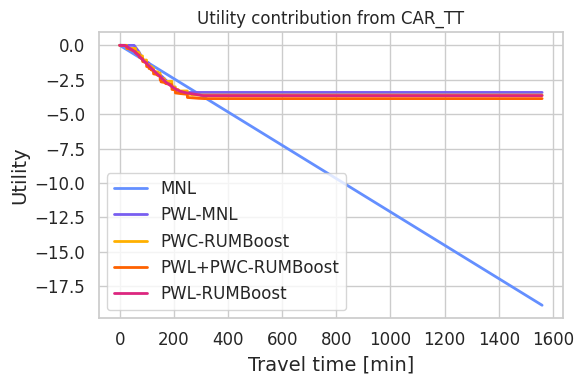

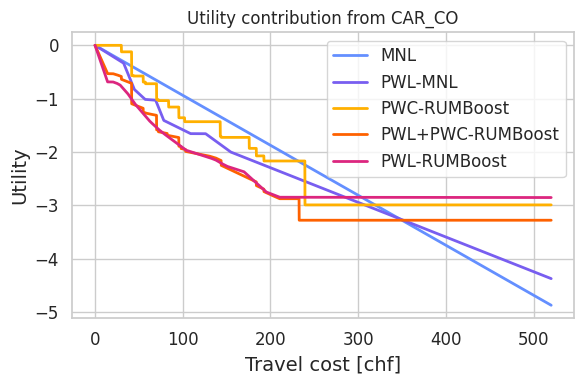

In [23]:
sns.set_theme(style="whitegrid")

models = {
    "MNL": lin_dcm,
    "PWL-MNL": pwl_dcm,
    "Const-RUMBoost": const_rumb,
    "PWL-Const-RUMBoost": lin_const_rumb,
    "PWL-RUMBoost": lin_rumb,
}
vars = [
    "TRAIN_TT",
    "TRAIN_COST",
    "TRAIN_HE",
    "SM_TT",
    "SM_COST",
    "SM_HE",
    "CAR_TT",
    "CAR_CO",
]

label_name = {
    "MNL": "MNL",
    "PWL-MNL": "PWL-MNL",
    "Const-RUMBoost": "PWC-RUMBoost",
    "PWL-Const-RUMBoost": "PWL+PWC-RUMBoost",
    "PWL-RUMBoost": "PWL-RUMBoost",
}

y_plot_mnl = []
y_plot_pwl = []
y_plot_crumb = []
y_plot_pwlcrumb = []
y_plot_pwl_rumb = []

y_plot = {
    "MNL": y_plot_mnl,
    "PWL-MNL": y_plot_pwl,
    "Const-RUMBoost": y_plot_crumb,
    "PWL-Const-RUMBoost": y_plot_pwlcrumb,
    "PWL-RUMBoost": y_plot_pwl_rumb,
}

for v in vars:
    if "TRAIN" in v:
        u = "0"
    elif "SM" in v:
        u = "1"
    elif "CAR" in v:
        u = "2"
    cols = [col for col in plot_dataset.columns if v in col]
    dummy_data = plot_dataset.copy()
    dummy_data[cols] = x_plot.reshape(-1, 1).repeat(len(cols), axis=1)
    dummy_data["choice"] = np.zeros_like(x_plot)
    for model_name, model in models.items():
        if model_name == "MNL":
            model_spec = SwissMetro_normalised(dummy_data, for_prob=True)
            preds = model_spec.simulate(lin_dcm.get_beta_values())[u]
            preds = preds - preds[0]
            y_plot_mnl.append(preds)
        elif model_name == "PWL-MNL":
            preds = predict_with_assisted_spec(
                dummy_data.drop(columns=["choice"]),
                dummy_data.drop(columns=["choice"]),
                np.zeros(dummy_data.shape[0]),
                np.zeros(dummy_data.shape[0]),
                lin_10bins_rumb,
                pwl_dcm.get_beta_values(),
                utilities=True,
            )[u]
            preds = preds - preds[0]
            y_plot_pwl.append(preds)
        elif model_name == "Const-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_crumb.append(preds)
        elif model_name == "PWL-Const-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_pwlcrumb.append(preds)
        elif model_name == "PWL-RUMBoost":
            dummy_data_lgb = lightgbm.Dataset(dummy_data, free_raw_data=False)
            preds = (
                model.predict(dummy_data_lgb, utilities=True)[:, int(u)].cpu().numpy()
            )
            preds = preds - preds[0]
            y_plot_pwl_rumb.append(preds)

colors = ["#648FFF", "#785EF0", "#FFB000", "#FE6100", "#DC267F"]

linestyles = ["-", "-", "-", "-", "-"]

for i, v in enumerate(vars):
    plt.figure(figsize=(6, 4))
    plt.title(f"Utility contribution from {v}")
    for j, model_name in enumerate(models.keys()):
        # if j < 2:
        #     continue
        # if j == 3:
        #     continue
        plt.plot(
            x_plot * X_train[v + "_constant"].max(),
            y_plot[model_name][i],
            label=label_name[model_name],
            linewidth=2,
            color=colors[j],
            linestyle=linestyles[j],
        )

    xlabel = (
        "Travel time [min]"
        if "TT" in v
        else "Travel cost [chf]" if "CO" in v else "Headway [min]"
    )
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("Utility", fontsize=14)
    #plt.ylim((y_plot["PWL-Const-RUMBoost"][i].min() * 1.05, -y_plot["PWL-Const-RUMBoost"][i].min()*0.05))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig(f"{path_to_save}utility_functions_{v}.png")

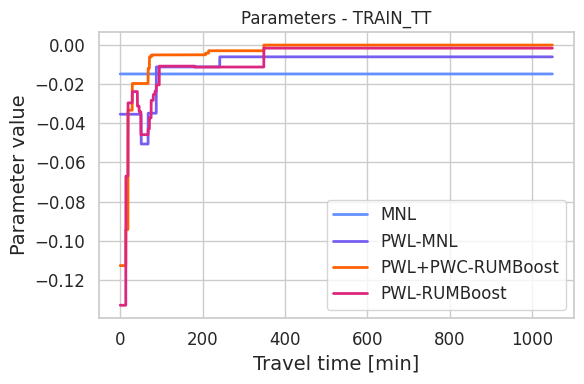

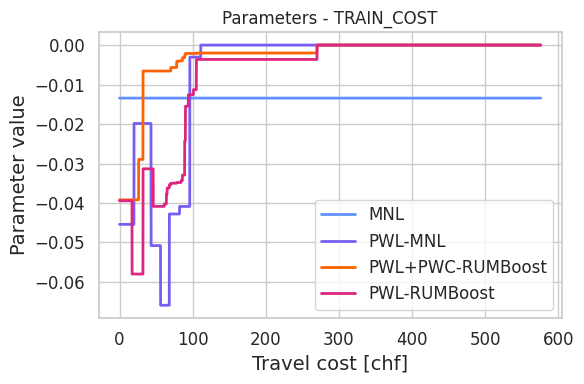

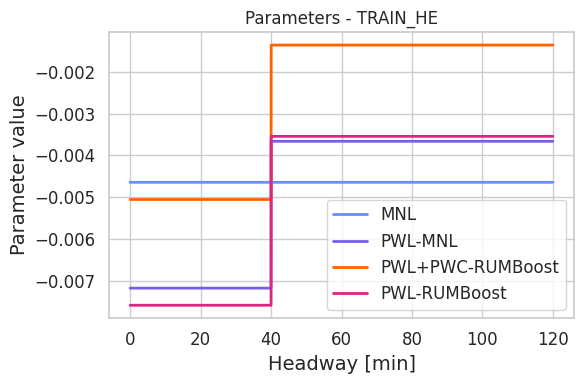

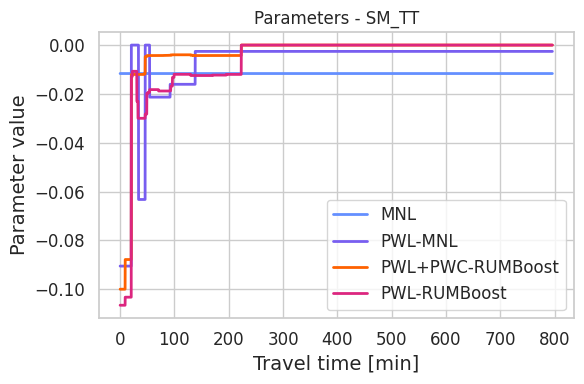

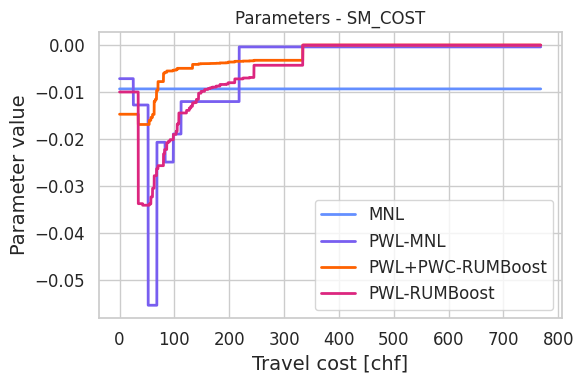

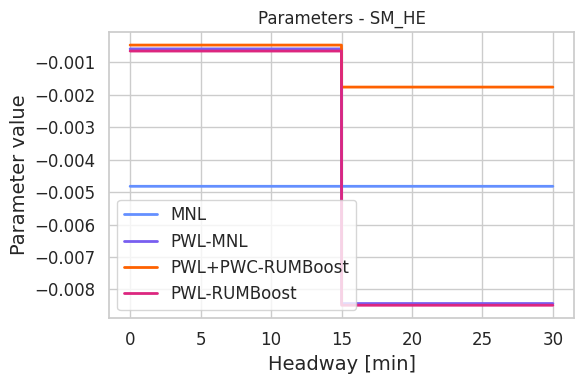

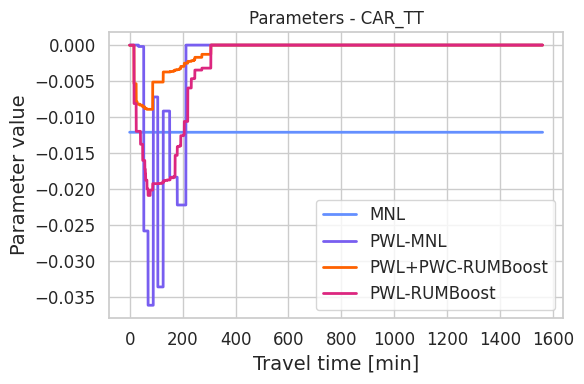

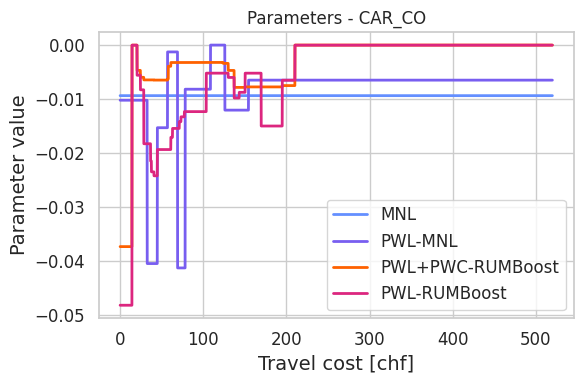

In [24]:
from rumboost.post_process import predict_with_assisted_spec
import matplotlib.pyplot as plt
import lightgbm
import seaborn as sns

sns.set_theme(style="whitegrid")

models = {
    "MNL": lin_dcm,
    "PWL-MNL": pwl_dcm,
    "PWL-Const-RUMBoost": lin_const_rumb,
    "PWL-RUMBoost": lin_rumb,
}
vars = [
    "TRAIN_TT",
    "TRAIN_COST",
    "TRAIN_HE",
    "SM_TT",
    "SM_COST",
    "SM_HE",
    "CAR_TT",
    "CAR_CO",
]
vars_to_b = {
    "TRAIN_TT": "B_TIME_RAIL",
    "TRAIN_COST": "B_COST_RAIL",
    "TRAIN_HE": "B_HE_RAIL",
    "SM_TT": "B_TIME_SM",
    "SM_COST": "B_COST_SM",
    "SM_HE": "B_HE_SM",
    "CAR_TT": "B_TIME_CAR",
    "CAR_CO": "B_COST_CAR",
}

label_name = {
    "MNL": "MNL",
    "PWL-MNL": "PWL-MNL",
    "Const-RUMBoost": "PWC-RUMBoost",
    "PWL-Const-RUMBoost": "PWL+PWC-RUMBoost",
    "PWL-RUMBoost": "PWL-RUMBoost",
}

y_plot_mnl = []
y_plot_pwl = []
y_plot_crumb = []
y_plot_pwlcrumb = []
y_plot_pwl_rumb = []

y_plot = {
    "MNL": y_plot_mnl,
    "PWL-MNL": y_plot_pwl,
    "PWL-Const-RUMBoost": y_plot_pwlcrumb,
    "PWL-RUMBoost": y_plot_pwl_rumb,
}

for v in vars:
    if "TRAIN" in v:
        u = "0"
    elif "SM" in v:
        u = "1"
    elif "CAR" in v:
        u = "2"
    cols = [col for col in plot_dataset.columns if v in col]
    dummy_data = plot_dataset.copy()
    dummy_data[cols] = x_plot.reshape(-1, 1).repeat(len(cols), axis=1)
    dummy_data["choice"] = np.zeros_like(x_plot)

    for model_name, model in models.items():

        if model_name == "PWL-Const-RUMBoost":
            booster_idx = [
                i
                for i, struct in enumerate(model.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            leaves = model.boosters[booster_idx].split_and_leaf_values["leaves"]
            splits = model.boosters[booster_idx].split_and_leaf_values["splits"]
            preds = leaves[
                np.clip(np.searchsorted(splits, x_plot) - 1, 0, len(leaves) - 1)
            ]
            y_plot_pwlcrumb.append(preds)
        elif model_name == "PWL-RUMBoost":
            booster_idx = [
                i
                for i, struct in enumerate(model.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            leaves = model.boosters[booster_idx].split_and_leaf_values["leaves"]
            splits = model.boosters[booster_idx].split_and_leaf_values["splits"]
            preds = leaves[
                np.clip(np.searchsorted(splits, x_plot) - 1, 0, len(leaves) - 1)
            ]
            y_plot_pwl_rumb.append(preds)
        elif model_name == "MNL":
            parameters = model.get_estimated_parameters()
            preds = parameters.loc[vars_to_b[v], "Value"] * np.ones_like(x_plot)
            y_plot_mnl.append(preds)
        elif model_name == "PWL-MNL":
            booster_idx = [
                i
                for i, struct in enumerate(lin_10bins_rumb.rum_structure)
                if v + "_linear" in struct["variables"]
            ][0]
            splits = lin_10bins_rumb.boosters[booster_idx].split_and_leaf_values[
                "splits"
            ]
            leaves = lin_10bins_rumb.boosters[booster_idx].split_and_leaf_values[
                "leaves"
            ]

            leaf_change_idx = np.where(leaves[:-1] != leaves[1:])[0]
            unique_splits = splits[leaf_change_idx + 1]
            indices = np.searchsorted(unique_splits, x_plot)
            parameters = model.get_estimated_parameters()
            preds = np.array(
                [
                    parameters.loc[f"b_{v}_linear_{booster_idx}_{i}", "Value"]
                    for i in indices
                ]
            )
            y_plot_pwl.append(preds)

colors = ["#648FFF", "#785EF0", "#FE6100", "#DC267F"]

linestyles = ["-", "-", "-", "-", "-"]

for i, v in enumerate(vars):
    plt.figure(figsize=(6, 4))
    plt.title(f"Parameters - {v}")
    for j, model_name in enumerate(models.keys()):
        # if j < 2:
        #     continue
        plt.plot(
            x_plot * X_train[v + "_constant"].max(),
            y_plot[model_name][i] / X_train[v + "_constant"].max(),
            label=label_name[model_name],
            linewidth=2,
            color=colors[j],
            linestyle=linestyles[j],
        )

    xlabel = (
        "Travel time [min]"
        if "TT" in v
        else "Travel cost [chf]" if "CO" in v else "Headway [min]"
    )
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel("Parameter value", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.savefig(f"{path_to_save}parameters_{v}.png")